In [39]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import neighbors
from sklearn import metrics
from sklearn import tree
from sklearn.tree import export_graphviz
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from operator import itemgetter
import time
import xgboost as xgb
from random import shuffle
from random import randint
import statsmodels.api as sm

In [40]:
pd.set_option("display.max_rows",50)
df1=pd.read_csv('Phishing_Legitimate_full.csv')

#koniecznie usuwamy id bo przypisuje do tej kolumny predykcje, anstenie model ma metryki 1
df1.drop(['id'],axis=1,inplace=True)

In [41]:
#podział zmiennych w modelu na numeryczne i kateogryczne 
target = 'CLASS_LABEL'
numFeatures = ['NumDots', 'SubdomainLevel', 'PathLevel', 'UrlLength', 'NumDash',
       'NumDashInHostname', 'NumUnderscore','NumPercent', 'NumQueryComponents', 'NumAmpersand',
       'NumNumericChars','HostnameLength', 'PathLength', 'QueryLength',
       'NumSensitiveWords']
catFeatures = ['AtSymbol','TildeSymbol','NumHash', 'NoHttps','RandomString', 'IpAddress','DomainInSubdomains','DomainInPaths','HttpsInHostname',
              'DoubleSlashInPath','EmbeddedBrandName','PctExtHyperlinks','PctExtResourceUrls', 'ExtFavicon', 'InsecureForms',
       'RelativeFormAction', 'ExtFormAction', 'AbnormalFormAction',
       'PctNullSelfRedirectHyperlinks', 'FrequentDomainNameMismatch',
       'FakeLinkInStatusBar', 'RightClickDisabled', 'PopUpWindow',
       'SubmitInfoToEmail', 'IframeOrFrame', 'MissingTitle',
       'ImagesOnlyInForm','ExtMetaScriptLinkRT','UrlLengthRT','SubdomainLevelRT',
       'PctExtResourceUrlsRT', 'AbnormalExtFormActionR',
       'PctExtNullSelfRedirectHyperlinksRT']

In [42]:
features = df.columns.tolist()
features.remove(target)
print(features)

['NumDots', 'SubdomainLevel', 'PathLevel', 'UrlLength', 'NumDash', 'NumDashInHostname', 'AtSymbol', 'TildeSymbol', 'NumUnderscore', 'NumPercent', 'NumQueryComponents', 'NumAmpersand', 'NumHash', 'NumNumericChars', 'NoHttps', 'RandomString', 'IpAddress', 'DomainInSubdomains', 'DomainInPaths', 'HttpsInHostname', 'HostnameLength', 'PathLength', 'QueryLength', 'DoubleSlashInPath', 'NumSensitiveWords', 'EmbeddedBrandName', 'PctExtHyperlinks', 'PctExtResourceUrls', 'ExtFavicon', 'InsecureForms', 'RelativeFormAction', 'ExtFormAction', 'AbnormalFormAction', 'PctNullSelfRedirectHyperlinks', 'FrequentDomainNameMismatch', 'FakeLinkInStatusBar', 'RightClickDisabled', 'PopUpWindow', 'SubmitInfoToEmail', 'IframeOrFrame', 'MissingTitle', 'ImagesOnlyInForm', 'SubdomainLevelRT', 'UrlLengthRT', 'PctExtResourceUrlsRT', 'AbnormalExtFormActionR', 'ExtMetaScriptLinkRT', 'PctExtNullSelfRedirectHyperlinksRT']


In [43]:
#wrapper XGBoost
def run_xgb(train, validate, features, target, # argumenty obowiązkowe
            eta=0.03, max_depth=7, subsample = 0.7, colsample_bytree = 0.7, # hiperparametry
            colsample_bylevel=1,lambdaX = 1, alpha=0, gamma=0, min_child_weight=0, # hiperparametry
            rate_drop = 0.2, skip_drop=0.5, # hiperparametry
            num_boost_round = 1000, early_stopping_rounds = 50, # hiperparametry
            debug=True, eval_metric= ["auc"], objective = "binary:logistic", # konfiguracja
            seed=2017, booster = "gbtree", tree_method="exact", grow_policy="depthwise"): # konfiguracja
    '''
    Uniwersalny wrapper dla XGB dla gbtree i dart
    Więcej opcji https://github.com/dmlc/xgboost/blob/master/doc/parameter.md
    
    Parametry
    ----------
    train, validate, features, target : wymagane zmienne bez domyślnych wartości
    train, validate : pd.DataFrames z kolumnami opisanymi w features i target
    features : lista zmiennych do wykorzystania w trenowaniu
    target : nazwa zmiennej objasnianej
    
    --- Zmienne wspólne dla gbtree i dart
        --- Zmienne właściwe dla Ensamble/Boosting
        eta : "learning rate"
        max_depth=7 : maksymalna głębokość drzew [0,∞]
        subsample : udział (0,1] obserwacji do treningu jednej iteracji
        colsample_bytree : udział (0,1] kolumn do treningu jednej iteracji
        colsample_bylevel : udział  (0,1] kolumn na poziom do treningu jednej iteracji
        --- Zmienne regularyzacyjne
        lambdaX=0 : regularyzacja L2 [0,∞]
        alpha=0 : regularyzacja L1 [0,∞]
        gamma=1 : minimalna redukcja funkcji straty
        min_child_weight=0 : minimalna suma wg poddrzewa

    --- Zmienne dla algorytmu dart
    rate_drop : 
    skip_drop : 
    
    --- Zmienne dla XGB, opis/agorytm/liczba drzew etc.
    num_boost_round : maksymalna liczba iteracji
    early_stopping_rounds : margines iteracji dla early stopping
    debug : Czy włączyć pełne opisy.
    eval_metric : Pełna lista dostępna https://github.com/dmlc/xgboost/blob/master/doc/parameter.md 
    objective : reg:linear, reg:logistic, binary:logistic, multi:softmax lub inne Pełna lista dostępna https://github.com/dmlc/xgboost/blob/master/doc/parameter.md 
    seed : random seed
    booster : ‘auto’, ‘exact’, ‘approx’, ‘hist’, ‘gpu_exact’, ‘gpu_hist’- silnik dla drzew gbtree (cart), dart (gbtree z dropoutem) lub gblinear
    tree_method : zobacz http://xgboost.readthedocs.io/en/latest/parameter.html
    grow_policy : depthwise, lossguide
    '''
   
    start_time = time.time()
    paramList= ['eta', 'max_depth',
         'subsample', 'colsample_bytree', 'colsample_bylevel',
         'lambdaX', 'alpha', 'gamma', 'min_child_weight',
         'num_boost_round', 'early_stopping_rounds',
         'rate_drop', 'skip_drop',
         'eval_metric', 'objective', 
          'seed', 'booster', 'tree_method', 'grow_policy']
    
    # Stworzenie słownika do przekazania do XGB
    params = dict()
    for param in paramList:
        params[param]=eval(param)
    if(debug):
        for param in paramList:
            print(param, eval(param), end=", ")
        print('\nLength train:', len(train.index))
        print('Length valid:', len(validate.index))

    # Automatyczne przekazanie liczby klas dla wielu poziomów klasyfikacji
    if (params["objective"]=="multi:softmax" or params["objective"]=="multi:softprob"):
        params["num_class"]=train[target].nunique()
    params["silent"]=1
    
    # XGB wymaga w słowniku parametrów słowa kluczowego lambda, poniżej workaround
    params["lambda"]=lambdaX
    
    # Przekształcenie zbiorów do struktury DMatrix
    # Struktura danych DMatrix pozwala na efektywne tworzenie drzew
    dtrain = xgb.DMatrix(train[features].values, train[target].values, feature_names=train[features].columns.values)
    dvalid = xgb.DMatrix(validate[features].values, validate[target].values, feature_names=validate[features].columns.values)

    # Stworzenie listy zbiorów do ealuacji
    evals = [(dtrain, 'train'), (dvalid, 'valid')]
    
    # Stworzenie zmiennej słownikowej do przekazania
    train_history = dict()

    # Uruchomienie algorytmu trenującego
    gbm = xgb.train(params, dtrain, 
                    num_boost_round, early_stopping_rounds=early_stopping_rounds,
                    evals=evals, evals_result=train_history, verbose_eval=debug)
    
    # Obliczenai statystyk i dodatkowych wartości
    score = gbm.best_score

    # Przekształcenie historii trenowania do Pandas Data Frame
    trainHistory = dict()
    for key in train_history.keys():
        for metric in train_history[key].keys():
            trainHistory[key+metric.upper()]=train_history[key][metric]
    train_history = pd.DataFrame(trainHistory)

    # Zapis przewidywanych wartości dla zbioru walidacyjnego dla najlepszej (z punktu widzenia walidacji) iteracji
    trainPred = gbm.predict(dtrain, ntree_limit=gbm.best_iteration)
    testPred = gbm.predict(dvalid, ntree_limit=gbm.best_iteration)

    # Przygotowanie posortowanej listy dla wazności zmiennych, zamaist słownika
    imp = gbm.get_fscore()
    imp = sorted(imp.items(), key=itemgetter(1), reverse=True)

    impFig=None
    if(debug):
        print('Czas trenowania: {} minut'.format(round((time.time() - start_time)/60, 2)))
        # Skorzystanie z wbudowanej funkcji wizualizującej waznośc zmiennych
        impFig, ax = plt.subplots()
        xgb.plot_importance(gbm, ax=ax)
    return score, trainPred, testPred, train_history, impFig, imp

In [44]:
test_size = 0.2
X_train, X_valid = train_test_split(df, test_size=test_size, random_state=2017, stratify=df[target].values)

eta 0.03, max_depth 7, subsample 0.7, colsample_bytree 0.7, colsample_bylevel 1, lambdaX 1, alpha 0, gamma 0, min_child_weight 0, num_boost_round 1000, early_stopping_rounds 50, rate_drop 0.2, skip_drop 0.5, eval_metric ['auc'], objective binary:logistic, seed 2017, booster gbtree, tree_method exact, grow_policy depthwise, 
Length train: 8000
Length valid: 2000
[18:31:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[0]	train-auc:0.96539	valid-auc:0.95669
[1]	train-auc:0.98517	valid-auc:0.97767
[2]	train-auc:0.99227	valid-auc:0.98903
[3]	train-auc:0.99397	valid-auc:0.99050
[4]	train-auc:0.99557	valid-auc:0.99252
[5]	train-auc:0.99622	valid-auc:0.99364
[6]	train-auc:0.99642	valid-auc:0.99425
[7]	train-auc:0.99688	valid-auc:0.99513
[8]	train-auc:0.99692	valid-auc:0.99499

C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


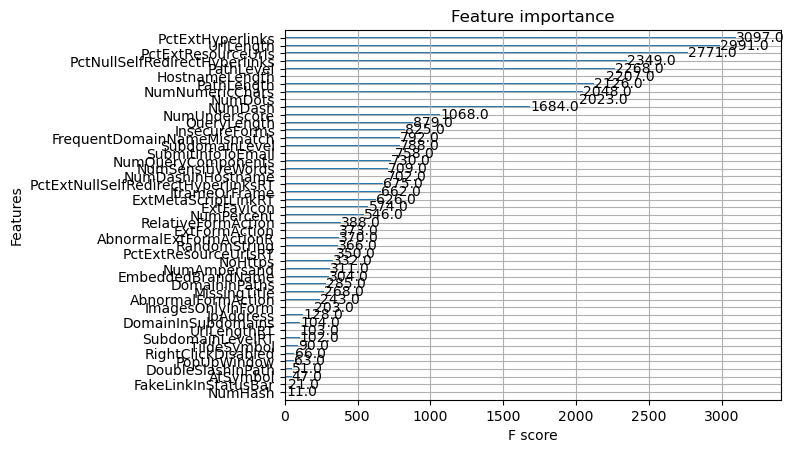

In [45]:
#pierwsza estymacja (bez walidacji krzyżowej)
score, trainPred, testPred, train_history, impFig, imp = run_xgb(X_train, X_valid, features, target, early_stopping_rounds=50)

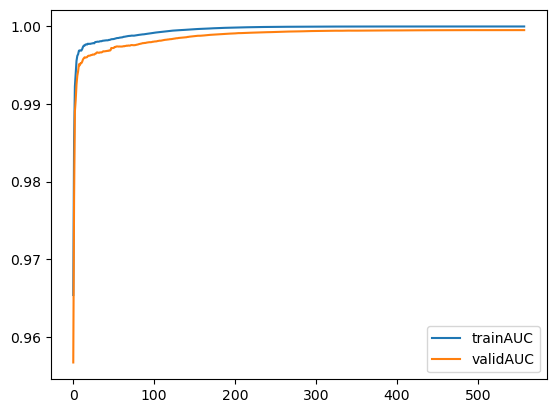

In [46]:
train_history.plot()
plt.show()

[18:31:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


4 0.999549
[18:31:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


6 0.999586
[18:31:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


8 0.999545
[18:31:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


10 0.999499
[18:31:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


12 0.999377
[18:31:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


14 0.999493


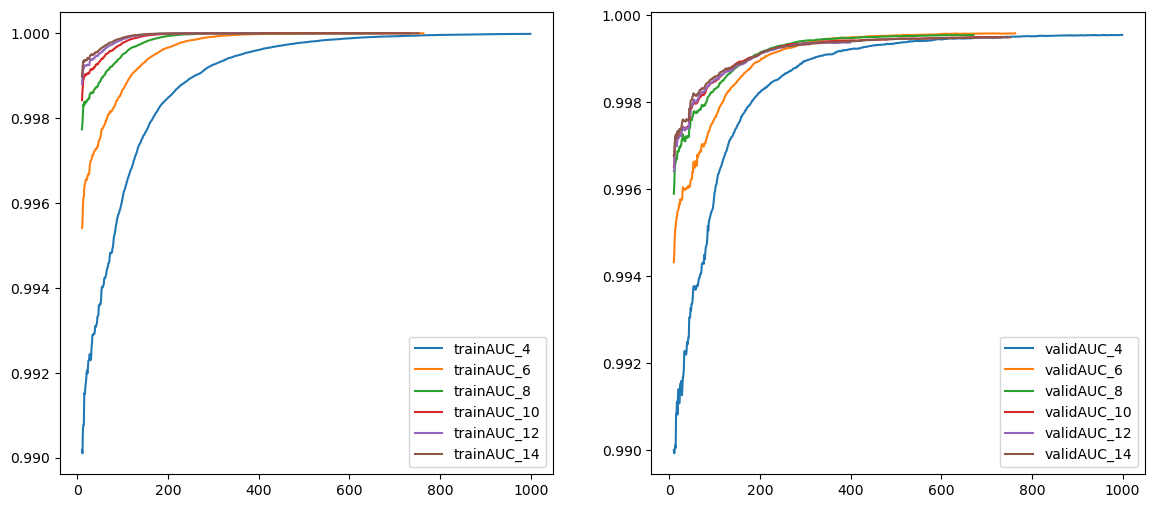

In [47]:
# szukanie hiperparametrów dla modelu (bez walidacji krzyżowej), tutaj max_depth
resHists = dict()
rang = range(4,15,2)
for x in rang:
    score, trainPred, testPred, train_history, impFig, imp = run_xgb(X_train, X_valid, features, target,
                                                          max_depth=x, early_stopping_rounds=50, debug=False)
    resHists[x]=train_history
    print(x, score)
fig, ax = plt.subplots(1, 2, figsize=(14,6))
for x in rang:
    resHists[x][['trainAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[0])
    resHists[x][['validAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[1])
plt.show()
#6 najlepsze

[11:00:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.3 0.999566
[11:00:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.4 0.999575
[11:00:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.5 0.999613
[11:00:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.6 0.999579
[11:00:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.7 0.999586
[11:00:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8 0.999578
[11:00:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.9 0.999504


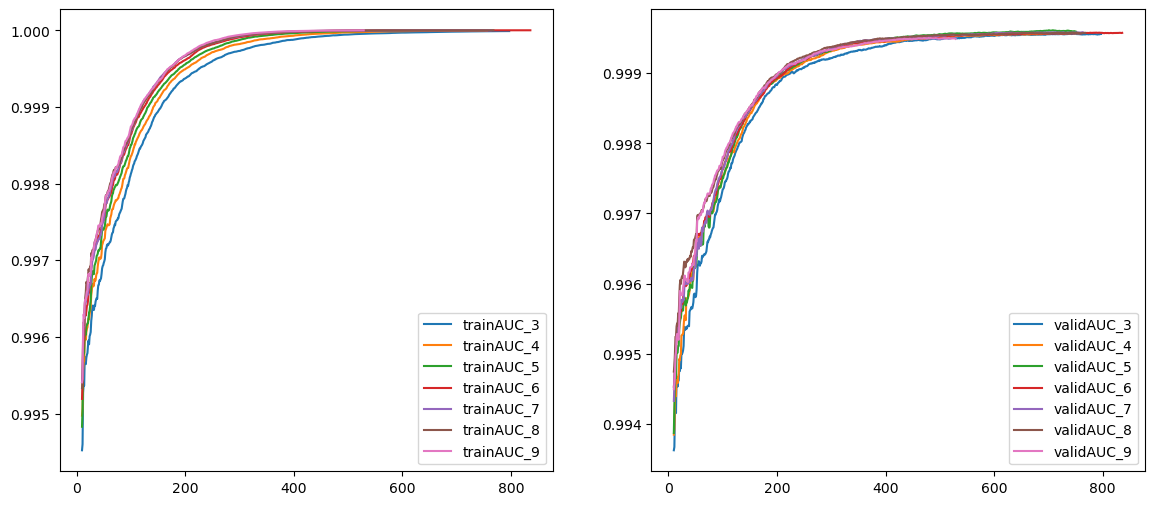

In [15]:
#tutaj szukamy procentu danych wysłanych do trenowania, to nam pomoże ograniczyć przetrenowanie
resHists = dict()
rang = range(3,10)
for x in rang:
    score, trainPred, testPred, train_history, impFig, imp = run_xgb(X_train, X_valid, features, target,
                                                          max_depth=6,  subsample=x/10,
                                                          early_stopping_rounds=50, debug=False)
    resHists[x]=train_history
    print(x/10, score)
fig, ax = plt.subplots(1, 2, figsize=(14,6))
# Dla zwiększenia czytelności wykresów przyjrzymy się historii po 10 obserwacji
for x in rang:
    resHists[x][['trainAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[0])
    resHists[x][['validAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[1])
plt.show()
#0,5 najlepsze

[11:01:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.3 0.999588
[11:01:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.4 0.999569
[11:01:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.5 0.999548
[11:01:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.6 0.999573
[11:01:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.7 0.999613
[11:01:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8 0.999606
[11:01:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.9 0.999548


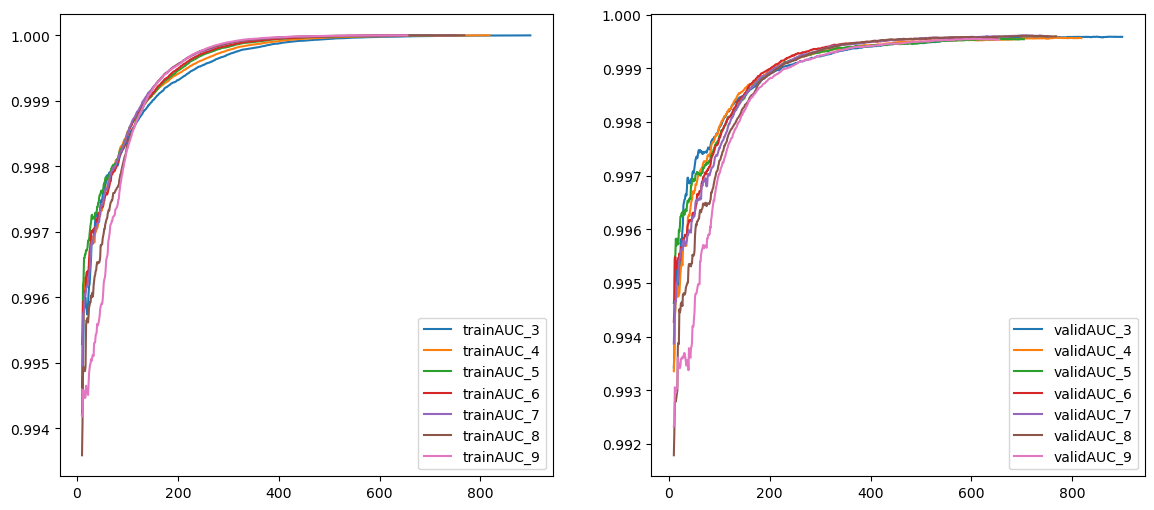

In [16]:
#następnie szukamy procentu zmiennych, z których stworzone będzie drzewo decyzyjne
resHists = dict()
rang = range(3,10)
for x in rang:
    score, trainPred, testPred, train_history, impFig, imp = run_xgb(X_train, X_valid, features, target,
                                                          max_depth=6, subsample=0.5, colsample_bytree=x/10,
                                                          early_stopping_rounds=50, debug=False)
    resHists[x]=train_history
    print(x/10, score)
fig, ax = plt.subplots(1, 2, figsize=(14,6))
# Dla zwiększenia czytelności wykresów przyjrzymy się historii po 10 obserwacji
for x in rang:
    resHists[x][['trainAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[0])
    resHists[x][['validAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[1])
plt.show()
#0,7 najlepsze

[11:02:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


3 0.999564
[11:02:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


4 0.999576
[11:02:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


5 0.999622
[11:02:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


6 0.99957
[11:02:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


7 0.999599
[11:02:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


8 0.99961
[11:02:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


9 0.99961
[11:02:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


10 0.999613


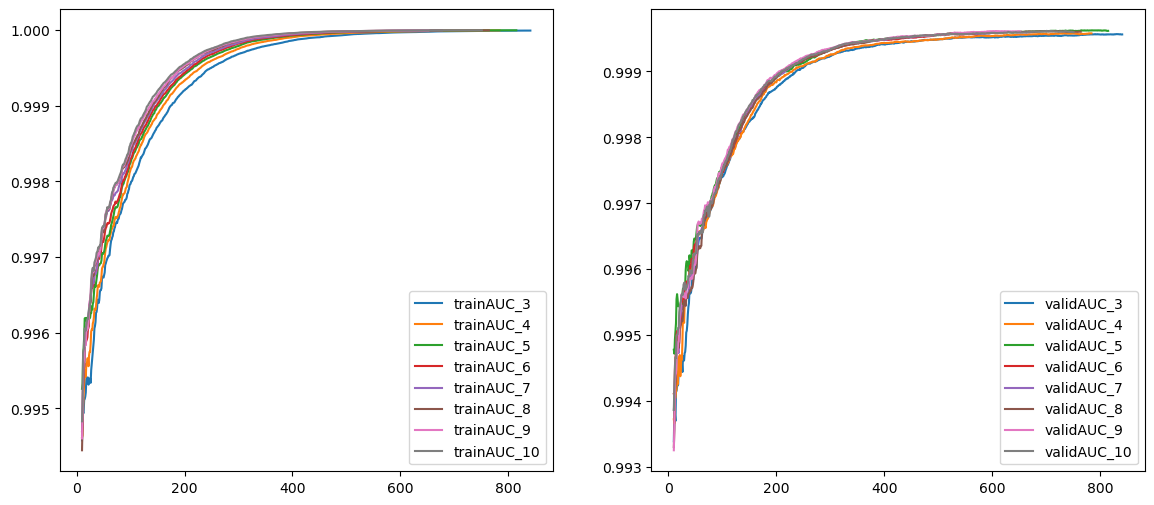

In [17]:
# procent zmiennych w podziale na dla kolejnego poziomu głębokości w drzewie decyzyjnym
resHists = dict()
rang = range(3,11)
for x in rang:
    score, trainPred, testPred, train_history, impFig, imp = run_xgb(X_train, X_valid, features, target,
                                                          max_depth=6, subsample=0.5, colsample_bytree=0.7, colsample_bylevel=x/10,
                                                          early_stopping_rounds=50, debug=False)
    resHists[x]=train_history
    print(x, score)
fig, ax = plt.subplots(1, 2, figsize=(14,6))
# Dla zwiększenia czytelności wykresów przyjrzymy się historii po 10 obserwacji
for x in rang:
    resHists[x][['trainAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[0])
    resHists[x][['validAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[1])
plt.show()
#0,5

[11:06:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.999622


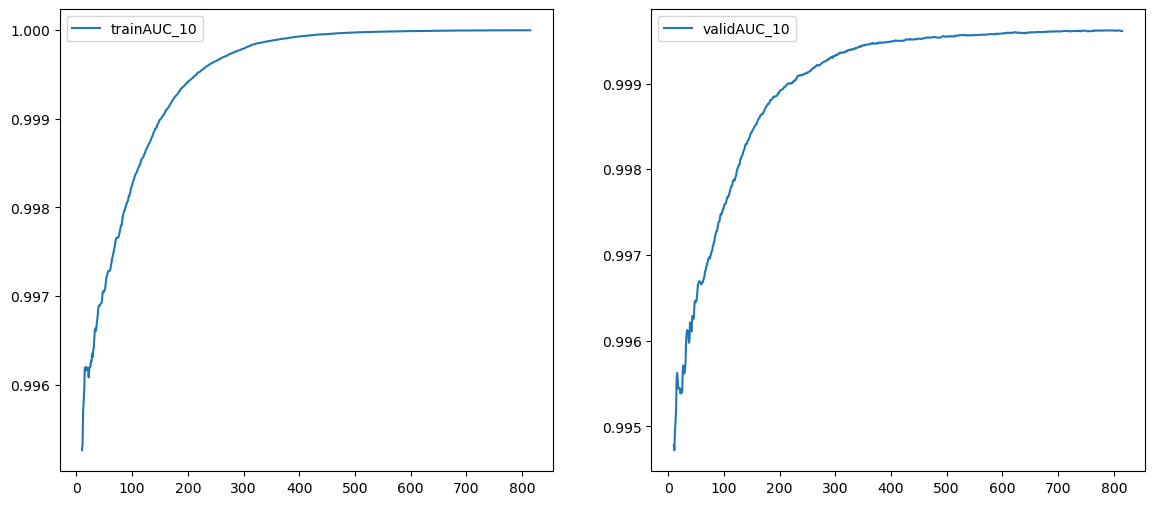

In [23]:
#trenowanie modelu dla znalezionych optymalnych wartości hiperparametrów
resHists = dict()

score, trainPred, testPred, train_history, impFig, imp = run_xgb(X_train, X_valid, features, target,
                                                          max_depth=6, subsample=0.5, colsample_bytree=0.7, colsample_bylevel=0.5,
                                                          early_stopping_rounds=50, debug=False)
resHists[x]=train_history
print(score)
fig, ax = plt.subplots(1, 2, figsize=(14,6))
# Dla zwiększenia czytelności wykresów przyjrzymy się historii po 10 obserwacji
resHists[x][['trainAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[0])
resHists[x][['validAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[1])
plt.show()
#najlepszy model bez walidacji krzyżowej

[11:07:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0 0.999634
[11:07:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


1 0.999613
[11:07:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


4 0.999561
[11:07:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


9 0.999454
[11:07:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


16 0.999409
[11:07:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


25 0.999305
[11:07:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


36 0.999163
[11:07:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


49 0.999034


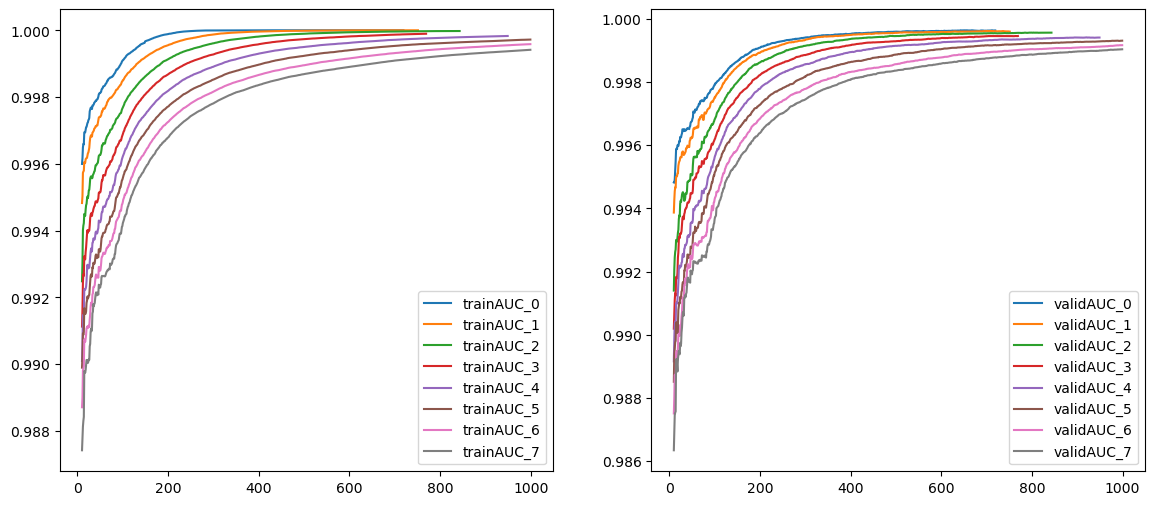

In [24]:
#uwzględnienie hiperparametru lambda, który odpowiada za regularyzacje L2
resHists = dict()

rang = range(0,8)
for x in rang:
    score, trainPred, testPred, train_history, impFig, imp = run_xgb(X_train, X_valid, features, target, lambdaX=x**2,
                                                          max_depth=6, subsample=0.5, colsample_bytree=0.7,
                                                          early_stopping_rounds=50, debug=False)
    
    print(x**2, score)
    resHists[x]=train_history
fig, ax = plt.subplots(1, 2, figsize=(14,6))
# Dla zwiększenia czytelności wykresów przyjrzymy się historii po 10 obserwacji
for x in rang:
    resHists[x][['trainAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[0])
    resHists[x][['validAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[1])
plt.show()
#lambdaX = 0

[11:08:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0 0.999634
[11:08:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.01 0.999612
[11:08:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.1 0.999652
[11:08:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.5 0.999572
[11:08:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


1 0.999511
[11:08:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


2 0.999444
[11:08:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


5 0.99918


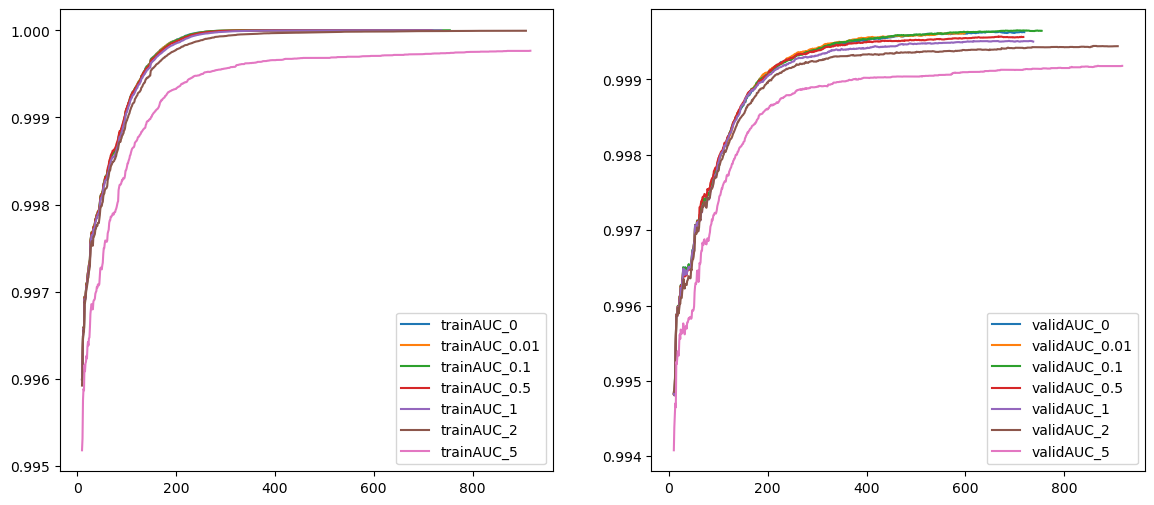

In [25]:
#szukamy minimalnej redukcji straty wymaganej do dalszego podziału węzła w drzewie w postaci współczynnika gamma
resHists = dict()
rang = [0, 0.01, 0.1, 0.5, 1, 2, 5]
for x in rang:
    score, trainPred, testPred, train_history, impFig, imp = run_xgb(X_train, X_valid, features, target, lambdaX=0,
                                                          max_depth=6, subsample=0.5, colsample_bytree=0.7,
                                                          gamma=x,
                                                          early_stopping_rounds=50, debug=False)
    resHists[x]=train_history
    print(x, score)
fig, ax = plt.subplots(1, 2, figsize=(14,6))
# Dla zwiększenia czytelności wykresów przyjrzymy się historii po 10 obserwacji
for x in rang:
    resHists[x][['trainAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[0])
    resHists[x][['validAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[1])
plt.show()
#gamma = 0.1

In [48]:
# wrapper walidacji krzyżowej dla algorytmu XGBoost
def CVTestXGB(nFolds = 5, randomState=2020, features=features, debug=False, *args, **kwargs):
    
    # Przygotujmy walidację krzyżową
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # Zapisanie wyników ze zbioru treningowego i testowego
    testResults = []
    trainResults = []
    
    # Przechowajmy również predykcje dla poszczególnych foldów
    predictions = []
    
    # Razem z informacją o tym, jaki był ich indeks w oryginalnym zbiorze danych
    indices = []
    
    # Przygotujmy listę historii
    hists = []
    fold = 1
    for train, test in kf.split(df.index.values):
        # Przygotowanie estymatora
        score, trainPred, testPred, train_history, impFig, imp = run_xgb(df.iloc[train], df.iloc[test],
                                                                         features, target, debug=debug, *args, **kwargs)

        # Zachowajmy informacje o predykcjach dla tego foldu
        predictions.append(testPred.tolist().copy())
        
        # Razem z indeksami w oryginalnym data frame
        indices.append(df.iloc[test].index.tolist().copy())
        
        # Informowanie o każdym foldzie razem z wynikami treningowymi możemy opcjonalnie wyświetlać w trakcie
        trainScore = roc_auc_score(df[target].iloc[train], trainPred)
        testScore = roc_auc_score(df[target].iloc[test], testPred)
        
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        hists.append(train_history.add_suffix('_'+str(fold)))
        fold+=1
        
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
        
    return trainResults, testResults, predictions, indices, pd.concat(hists, axis=1)

In [27]:
#patrzymy czy wyniki dla modelu z użyciem XGBoost bez walidacji krzyżowej będą bardzo dobre
trainResults, testResults, predictions, indices, hists = CVTestXGB(
    max_depth=6, lambdaX=0, subsample=0.5, colsample_bytree=0.7, gamma=0.1, debug=False)
np.mean(trainResults), np.mean(testResults)

[11:09:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[11:09:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[11:09:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[11:09:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[11:09:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


(0.9999975874950054, 0.9989557429834693)

[18:32:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:32:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:32:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:32:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:32:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


4 0.9988462715445069
[18:32:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:32:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:32:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:32:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:32:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


5 0.9989573191992335
[18:32:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:32:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:32:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:32:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:32:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


6 0.9989611021962016
[18:32:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:32:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:32:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:32:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:32:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


7 0.9989931144044206
[18:32:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:32:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:32:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:32:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:32:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


8 0.9990129131595044
[18:32:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:33:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:33:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:33:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:33:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


9 0.9990182889318922
[18:33:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:33:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:33:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:33:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:33:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


10 0.9990174965528137
[18:33:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:33:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:33:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:33:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:33:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

11 0.9990137065638465


C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


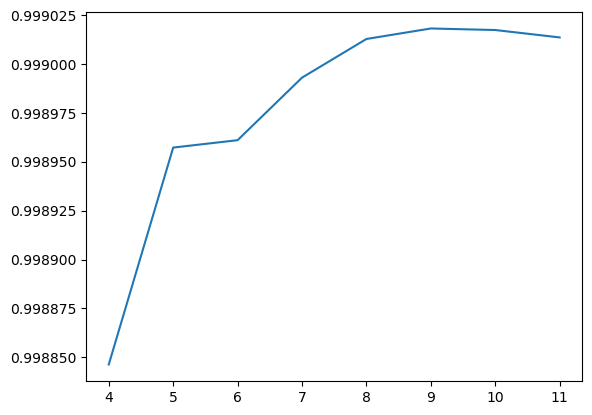

In [49]:
#ponownie będziemy szukać tych hiperparametrów, które dadzą najlepsze wyniki, głębokość
rang = range(4,12)
results = []
for x in rang:
    trainResults, testResults, predictions, indices, hists = CVTestXGB(
        max_depth=x)
    print(x, np.mean(testResults))
    results.append(np.mean(testResults))
    
plt.plot(list(rang), results)
plt.show()
#9 najlepsze

[18:33:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:33:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:34:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:34:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:34:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


2 0.9989159079895213
[18:34:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:34:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:34:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:34:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:34:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


3 0.9989028877338774
[18:34:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:34:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:34:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:34:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:34:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


4 0.9990323112761933
[18:34:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:34:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:34:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:34:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:34:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


5 0.9989760935731284
[18:34:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:34:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:34:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:34:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:35:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


6 0.9990199108349958
[18:35:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:35:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:35:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:35:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:35:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


7 0.9990182889318922
[18:35:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:35:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:35:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:35:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:35:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


8 0.998930490261263
[18:35:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:35:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:35:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:35:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:35:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

9 0.9989865012273433


C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


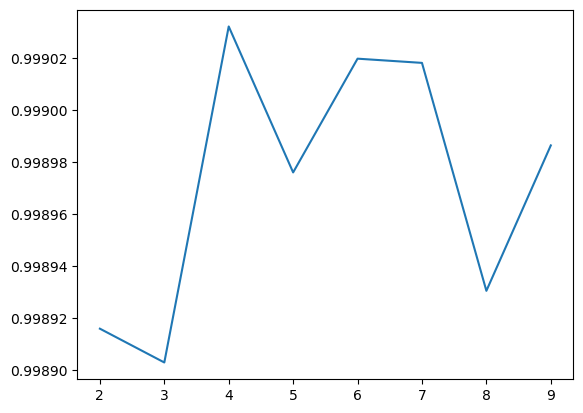

In [50]:
#procent danych wysłanych do trenowania
rang = range(2,10)
results = []
for x in rang:
    trainResults, testResults, predictions, indices, hists = CVTestXGB(
        max_depth=9, subsample = x/10)
    print(x, np.mean(testResults))
    results.append(np.mean(testResults))
    
plt.plot(list(rang), results)
plt.show()
#0.4 najlepsze

[18:35:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:36:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:36:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:36:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:36:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


2 0.9988076680829288
[18:36:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:36:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:36:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:36:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:36:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


3 0.9988482645342491
[18:36:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:36:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:36:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:36:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:36:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


4 0.998917120562048
[18:36:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:36:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:36:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:36:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:36:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


5 0.9989529292289185
[18:36:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:36:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:36:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:36:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:36:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


6 0.9989619293796714
[18:36:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:36:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:36:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:36:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:37:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


7 0.9989813313909135
[18:37:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:37:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:37:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:37:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:37:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


8 0.9989740992362399
[18:37:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:37:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:37:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:37:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:37:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

9 0.999000723382942


C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


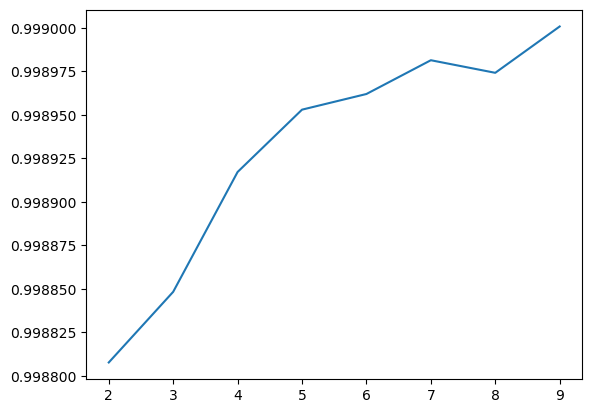

In [51]:
#procent zmiennych, z których stworzone będzie drzewo decyzyjne
rang = range(2,10)
results = []
for x in rang:
    trainResults, testResults, predictions, indices, hists = CVTestXGB(
        max_depth=7, subsample = 0.4, colsample_bytree = x/10)
    print(x, np.mean(testResults))
    results.append(np.mean(testResults))
    
plt.plot(list(rang), results)
plt.show()
#dla 9 najlepsze

[18:37:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:37:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:37:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:38:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:38:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0 0.9989002187556053
[18:38:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:38:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:38:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:38:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:38:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


1 0.9989677126386614
[18:38:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:38:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:38:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:38:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:38:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


4 0.9989250635920051
[18:38:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:38:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:38:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:38:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:39:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


9 0.9988402021931652
[18:39:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:39:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:39:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:39:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:39:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


16 0.998752743528749
[18:39:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:39:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:39:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:39:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:39:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


25 0.9986408689587707
[18:39:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:40:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:40:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:40:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:40:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


36 0.9985087613867701
[18:40:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:40:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:40:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:40:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:40:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

49 0.9983756757146078


C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


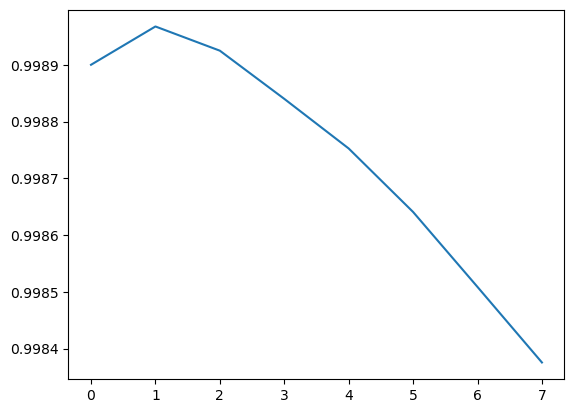

In [52]:
#regularyzacja L2
rang = range(0,8)
results = []
for x in rang:
    trainResults, testResults, predictions, indices, hists = CVTestXGB(
        max_depth=9, subsample = 0.4, colsample_bytree = 0.9, lambdaX=x**2)
    print(x**2, np.mean(testResults))
    results.append(np.mean(testResults))
    
plt.plot(list(rang), results)
plt.show()
#lambdaX = 1

[18:41:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:41:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:41:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:41:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:41:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.01 0.998946278760536
[18:41:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:41:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:41:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:41:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:41:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.1 0.9989392581220518
[18:41:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:41:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:41:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:41:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:41:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.5 0.9988768120486091
[18:41:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:41:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:42:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:42:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:42:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


1 0.9987905731983922
[18:42:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:42:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:42:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:42:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:42:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


2 0.998645289569844
[18:42:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:42:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:42:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:42:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:42:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


4 0.9983567272129046
[18:42:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:42:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:42:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:42:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:43:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


6 0.9980035486665259
[18:43:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:43:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:43:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:43:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:43:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


8 0.9976030979803052
[18:43:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:43:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:43:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:43:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:43:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


10 0.9972126806551683
[18:43:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:43:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:43:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:43:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:43:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

15 0.9961293600435097


C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


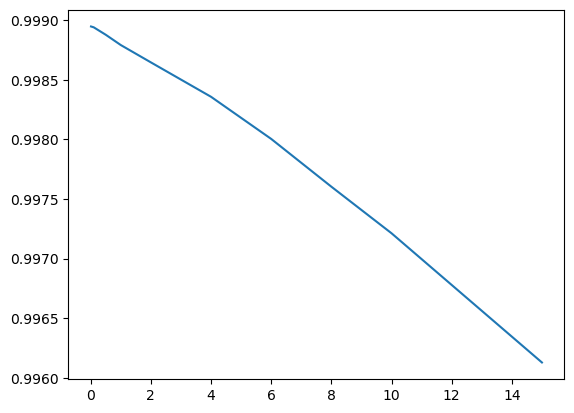

In [53]:
#gamma
rang = [0.01, 0.1, 0.5, 1, 2, 4, 6, 8, 10, 15]
results = []
for x in rang:
    trainResults, testResults, predictions, indices, hists = CVTestXGB(
        max_depth=9, subsample = 0.4, colsample_bytree = 0.9, lambdaX=1, gamma=x)
    print(x, np.mean(testResults))
    results.append(np.mean(testResults))
    
plt.plot(list(rang), results)
plt.show()
#gamma = 0.01

In [54]:
#najlepszy model jaki udało się nam wytrenować, ma to sens ze względu na to, że algorytm XGBoost jest w prawdzie połączeniem algorytmu RandomForest (dla którego wyniki też były świetne) i boostingu
trainResults, testResults, predictions, indices, hists = CVTestXGB(
        max_depth=9, subsample = 0.4, colsample_bytree = 0.9, lambdaX=1, gamma=0.01)
print(np.mean(testResults))

modelXGB = {
    "name":"XGB",
    "description":"Model XGB, ze zmiennymi kategorycznymi z LE",
    "specification":'max_depth=9, subsample = 0.4, colsample_bytree = 0.9, lambdaX=1, gamma=0.01',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

[18:44:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:44:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:44:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:44:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[18:44:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

0.998946278760536


C:\Users\jsmig\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


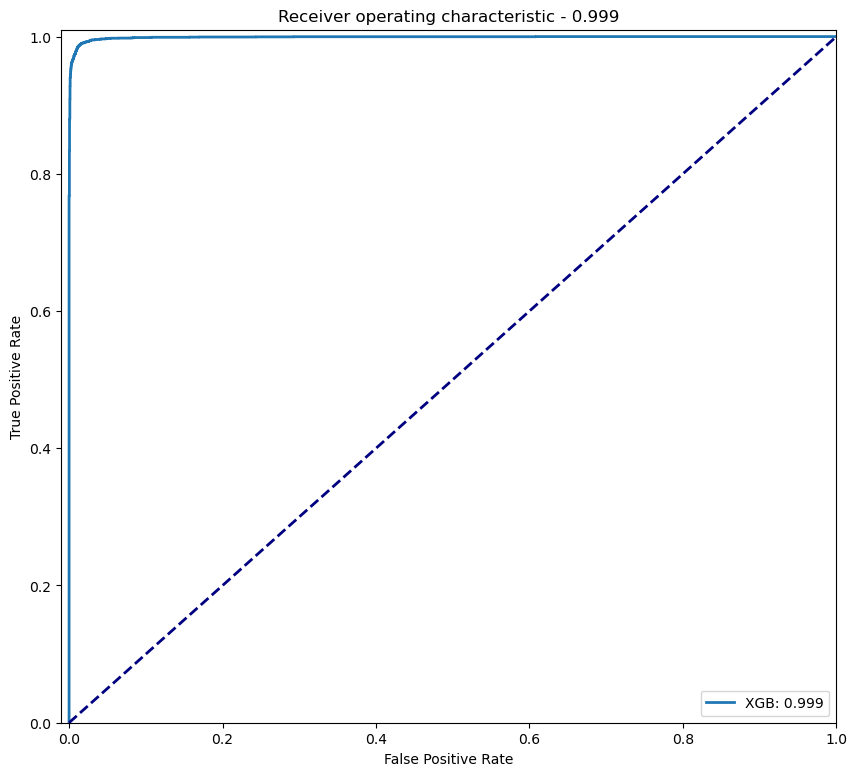

In [55]:
def plotROCs(results):
    ''' Funkcja, do rysowania szeregu wyników krzywych ROC dla poszczególnych eksperymentów
    results - lista wyników jako 3 elementowe tuple (true, pred, label)
    '''

    # Ustalanie wielkości rysunku
    fig, ax = plt.subplots(figsize=(10,9))

    for true, pred, label in results:
        # Obliczenie punktów potrzebnych do narysowani akrzywej ROC
        # funkcja roc_curve zwarca trzy serie danych, fpr, tpr oraz poziomy progów odcięcia
        fpr, tpr, thresholds = roc_curve(true, pred)
        # Obliczamy pole powierzchni pod krzywą
        rocScore = roc_auc_score(true, pred)
        rocScore = round(rocScore, 3)

        # Grubość krzywej
        lw = 2

        # Rysujemy krzywą ROC
        ax.plot(fpr, tpr, lw=lw, label=f'{label}: {rocScore}')
    # Rysujemy krzywą 45 stopni jako punkt odniesienia
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    # Dodajemy lekkie marginesy do zakresu aby krzywa nie pokrywała się z osiami
    ax.set_xlim([-0.01, 1.0])
    ax.set_ylim([0.0, 1.01])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'Receiver operating characteristic - {rocScore}')
    ax.legend(loc="lower right")
    plt.show()

res2plot = []
true = (df[target]==1).sort_index()
pred = pd.Series(sum(modelXGB["predictions"], []), index=sum(modelXGB["indices"], [])).sort_index()
res2plot.append((true, pred, modelXGB["name"]))

plotROCs(res2plot)